In [2]:
import Pkg
Pkg.activate("../../Tasks2D")
using Revise, Plots

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [3]:
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

In [4]:
### Construct Environment ###
includet("09/model.jl") # Loads variables: uniform_agent_pos, motion_model, sensor_model

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#332", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#333", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#334", Bool[0, 0], false), var"#13#14"())

In [5]:
# Particle filter for the model above.
includet("09/pf.jl")          # Loads: @get_pf

# A* navigation, using conversion to discrete coordinates.
includet("09/astar_nav.jl")   # Loads: line_to_grid, taxi_dist, find_action_using_grid_search

# Wall following behavior.
includet("09/wall_follow.jl") # Loads: initial_wall_follow_state, wall_follow

# Rule for whether a belief state is sufficiently uncertain to be worth disambiguating.
includet("09/uncertainty_thresholding.jl") # Loads: there_is_ambiguity

In [6]:
# Visualizations.
includet("09/visualize.jl") # Loads: trace_to_gif, trace_to_path_image

In [7]:
# Load the map (line segments, bounding box)
(_segs, _bb, _) = #L.load_env_sparse("../../data/environments/ambig.json");
    L.load_env_sparse("../../data/environments/000d0395709d2a16e195c6f0189155c4.json");

In [8]:
# Parameters for the grid discretization used for planning
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])));

In [9]:
### Ground truth world model parameters ###
PARAMS = (;
    map = _segs, orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; Δ = 0.25, σ = 0.005 ),
    obs = (; fov = 2π, n_rays = 40,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

In [11]:
_bb

([0.1, 0.1], [20.42, 11.76])

In [12]:
avg(x, y) = (x+y)/2
center = [avg(_bb[1][1], _bb[2][1]), avg(_bb[1][2], _bb[2][2])]

2-element Vector{Float64}:
 10.260000000000002
  5.93

In [14]:
Δy = _bb[2][2] - _bb[1][2]
Δx = _bb[2][1] - _bb[1][1]
y_to_x = Δy/Δx

# Want: Δy/step * Δx/step ≈ 400
#       Δx^2/step^2 * y_to_x = 400
#       step^2 = Δx^2 * y_to_x / 400
#       step = sqrt(Δx^2 * y_to_x / 400)
step = sqrt(Δx^2 * y_to_x / 400)
@assert Δy/step * Δx/step ≈ 400
step

0.7696284818014468

In [18]:
nstepsy = Int(floor(Δy/step))
nstepsx = Int(floor(Δx/step))
[nstepsx, nstepsy]

2-element Vector{Int64}:
 26
 15

In [49]:
### Particle Filter args ###
_grid_args = (;
    tau = 1., pmin = 1e-6, n_iters = 5,
    init_grid_args = (; k = [9, 9], r = [PARAMS.step.Δ/3, PARAMS.step.Δ/3]),
)
_t0_grid_args = (;
    _grid_args..., tau=1., n_iters=6,
    # TODO: set this up to automatically look at the bounding box
    # init_grid_args = (; k=[14, 26], r=[.4, .4]), initial_pos = [2.7, 6.]
    
    # DONE!
    init_grid_args = (; k=[nstepsx, nstepsy], r = [step, step]), initial_pos = center
)

INFERENCE_PARAMS = (;
    PARAMS...,
    step = (; Δ = 0.25, σ = 0.1),
    obs = (; PARAMS.obs..., sensor_args=(;
        PARAMS.obs.sensor_args...,
        s_noise = 0.2,
    ))
)

# 1 particle!
_resampling_args = (; n_particles=1, n_groups=1, ess_threshold=0.)

### Particle filter ###
pf = @get_pf(INFERENCE_PARAMS, _grid_args, _t0_grid_args, _resampling_args);
(pf_init, pf_update) = pf;

In [50]:
### Calibrate lm estimate threshold ###

# Step 1: collect a bunch of samples of p(obs | state) for random states generated from the initial timestep model
logpy_values = []
for _=1:1000
    state = uniform_agent_pos(INFERENCE_PARAMS)
    obs_tr = simulate(sensor_model, (state, INFERENCE_PARAMS))
    push!(logpy_values, get_score(obs_tr))
end

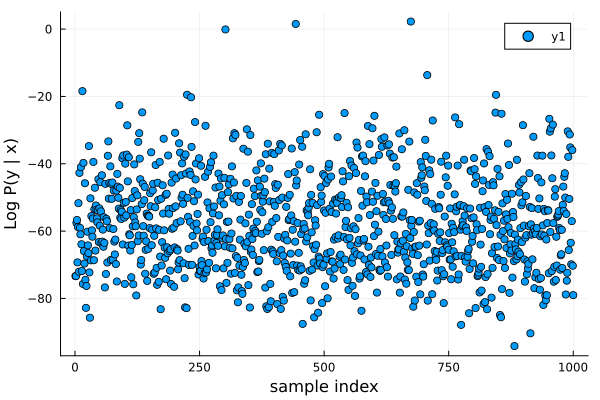

In [51]:
scatter(1:1000, logpy_values, ylabel="Log P(y | x)", xlabel="sample index")

In [52]:
delta = maximum(logpy_values) - minimum(logpy_values)

# Heuristic.  [TODO -- think more about principled ways of setting such thresholds.]
logpy_threshold = minimum(logpy_values) - max(delta, 10)

-190.52374198979805

In [53]:
is_shockingly_low(log_py_estimate) = log_py_estimate < logpy_threshold

is_shockingly_low (generic function with 1 method)

In [54]:
initial_controller_state = (nothing, nothing) # pf state, prev action, previous lml estimate for trace

@gen function controller(st, obs)
    # Unpack controller state
    pf_state, prev_action = st
    
    # Create 1-particle belief state
    if isnothing(prev_action) # First timestep
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        prev_lml_est = GenParticleFilters.get_lml_est(pf_state)
        pf_state = pf_update(pf_state, prev_action, choicemap((:obs, obs)))
        new_lml_est = GenParticleFilters.get_lml_est(pf_state)
        if is_shockingly_low(new_lml_est - prev_lml_est)
            # Reset the particle filter!
            pf_state = pf_init(choicemap((:obs, obs)))
        end
    end

    # Choose action
    action = find_action_using_grid_search(currentpos(pf_state.traces[1]), GOAL)[1]

    # Occasionally, mismatch between the grid map and the continuous map will cause the
    # A* controller to push the agent into a wall.
    # To fix it, we just notice if it looks like the agent is running into a wall;
    # if so, we take a step orthogonal to the wall.
    pf_T = T(pf_state.traces[1])
    if pf_T > 0
        prev_pos = pf_state.traces[1][GenPOMDPs.state_addr(pf_T - 1)]
        pos = pf_state.traces[1][GenPOMDPs.state_addr(pf_T)]
        if taxi_dist(pos, prev_pos) < ϵ/10 && action == prev_action
            if prev_action in (:left, :right)
                action = rand() < .5 ? :up : :down
            else
                action = rand() < .5 ? :left : :right
            end
        end
    end
    
    # Return action and new controller state
    return (action, (pf_state, action))
end

controller = GenPOMDPs.Controller(controller, initial_controller_state)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##controller#1167", Bool[0, 0], false), (nothing, nothing))

In [31]:
GOAL = center; #[1., 4.];

In [55]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#1236"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_LQ1GjUd0pm.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_LQ1GjUd0pm.gif")
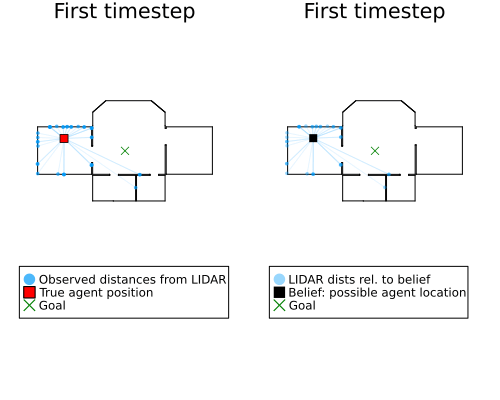

In [69]:
# Simulate rollout to the end of T=0 (ie. generate initial state + obs, and an initial action)
rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
# choicemap((GenPOMDPs.state_addr(0, :pos), [2, 5]))
)[1]

trace_to_gif(rollout_tr; goal=GOAL, title="First timestep")

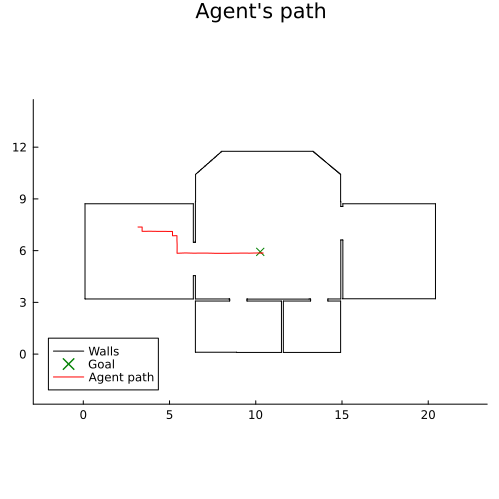

In [70]:
# Extend rollout to 40 steps...
rollout_tr, _ = Gen.update(rollout_tr, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())

trace_to_path_image(rollout_tr; goal=GOAL)

┌ Info: Saved animation to /tmp/jl_Jkpq3OLAzq.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Jkpq3OLAzq.gif")
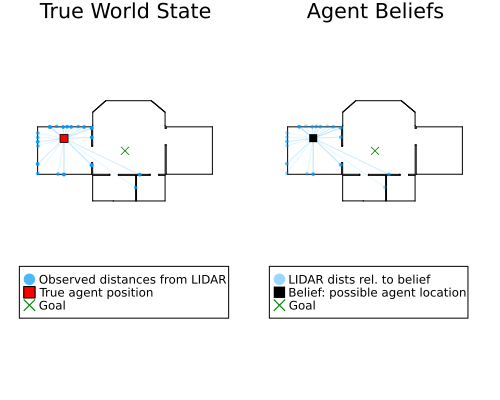

In [71]:
trace_to_gif(rollout_tr; goal=GOAL, fps=10)

In [ ]:
# Below -- visualization of the lml estimates that arose during inference.  Useful for understanding
# the behavior of the LML threshold controller

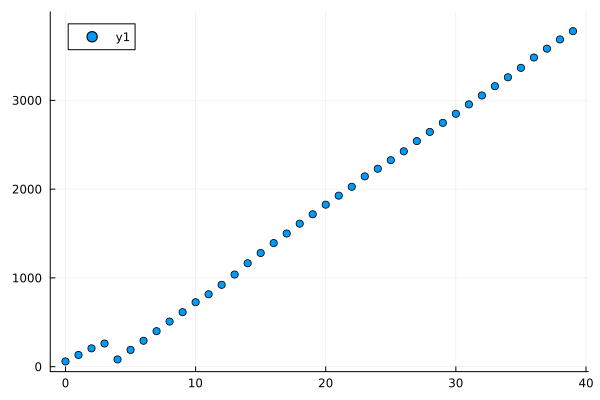

In [135]:
scatter(0:39, [GenParticleFilters.get_lml_est(pfst)
    for (pfst, _) in GenPOMDPs.controllerstate_sequence(rollout_tr)])

In [136]:
lml_ests = [GenParticleFilters.get_lml_est(pfst)
for (pfst, _) in GenPOMDPs.controllerstate_sequence(rollout_tr)]
deltas = [x - y for (x, y) in zip(lml_ests[2:end], lml_ests[1:end-1])]

40-element Vector{Float64}:
   73.0051654946014
   74.23497460041725
   54.473456718363764
 -179.2254936852627
  107.21658402255238
  103.1042599562287
  107.83619705816363
  108.26615427434592
  105.87179527874957
  112.1219481855718
    ⋮
  100.28243972916698
  104.84035055614186
  100.06964667028433
  106.4043402840066
  116.32289315010894
   99.57750997508356
  103.81769472482483
   93.6099991217111
  103.04119243317291

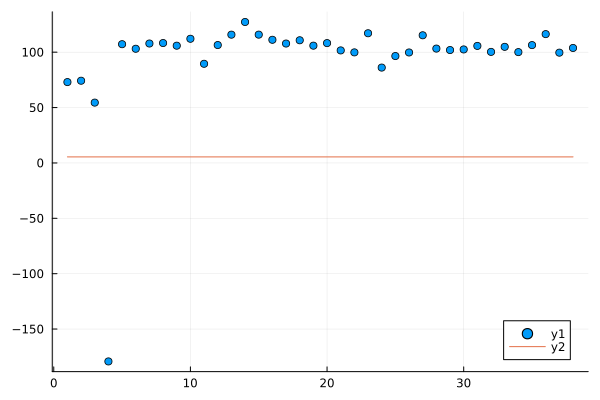

In [137]:
lml_ests = [GenParticleFilters.get_lml_est(pfst)
for (pfst, _) in GenPOMDPs.controllerstate_sequence(rollout_tr)]
deltas = [x - y for (x, y) in zip(lml_ests[2:end], lml_ests[1:end-1])]
scatter(1:38, deltas)
plot!(1:38, [logpy_threshold for _ in 1:38])